# Stage I

1) сгенерить waveform синуса,  с напр., 10k отсчетов (на один период) (1 Hz)

2) нарисовать его, нарисовать fft, и попробовать правильно подписать оси и деления шкал на них ;)

3) сымитировать оцифровку -- понизить чсило отсчетов например а) до 500, и до 25 — и повторить п.2, при этом увидеть какие искажения в спектре возникли

4) сымитировать "кривую" оцифровку -- при уменьшении частоты дескритезации брать отсчеты с разным смещением в лево и вправо,
(аналог физовых искажений, jitter), и снова посмотреть 2) на 5-10% периода

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, rfft
from scipy import signal
from typing import Tuple, List, TypeVar
import random
import math

%matplotlib inline

In [2]:
def sin_tick(sampling_rate: int, period: int = 1) -> Tuple[np.array, np.array]:
    x = np.linspace(0, 1 * int(period), sampling_rate, endpoint=True)
    y = np.sin(2 * np.pi * x)
    return x, y
def rand_sigh():
    return -1 if random.random() > 0.5 else 1.0

In [3]:
def sin_tick_rand_jitter(sampling_rate: int, periods_count: int, jitter_tick_max_percent: float = 0.0, jitter_magnitude_max_percent: float = 0.0) -> Tuple[np.array, np.array]:
    random.seed(1112220)
    x = []
    size = 0.
    jit_tick = (float(jitter_tick_max_percent) / 100.)
    jit_mag = (float(jitter_magnitude_max_percent) / 100.)
    lin_x = np.linspace(0, periods_count, sampling_rate, endpoint=True)
    for i, ix in enumerate(lin_x):
        if i in {0, sampling_rate}:
            x.append(float(ix))
            continue
        xf = float(ix)
        if size == 0.:
            size = abs(xf)
        xf = xf + size * jit_tick * rand_sigh()
        x.append(xf)
    random.seed(3312220)
    y = []
    for ix in x:
        yi = 1 * math.sin(2 * math.pi * ix)
        yi = yi + abs(yi) * jit_mag * rand_sigh()
        y.append(yi)
    assert jitter_tick_max_percent == 0. or jitter_magnitude_max_percent == 0.
    if jitter_tick_max_percent != 0.:
        return lin_x, np.array(y)
    return np.array(x), np.array(y)

# FFT

[scipy.fftpack](https://docs.scipy.org/doc/scipy/reference/fftpack.html)

`fft(x, n)` - Return discrete Fourier transform of real or complex sequence.

`fftshift(x)` - Shift the zero-frequency component to the center of the spectrum.

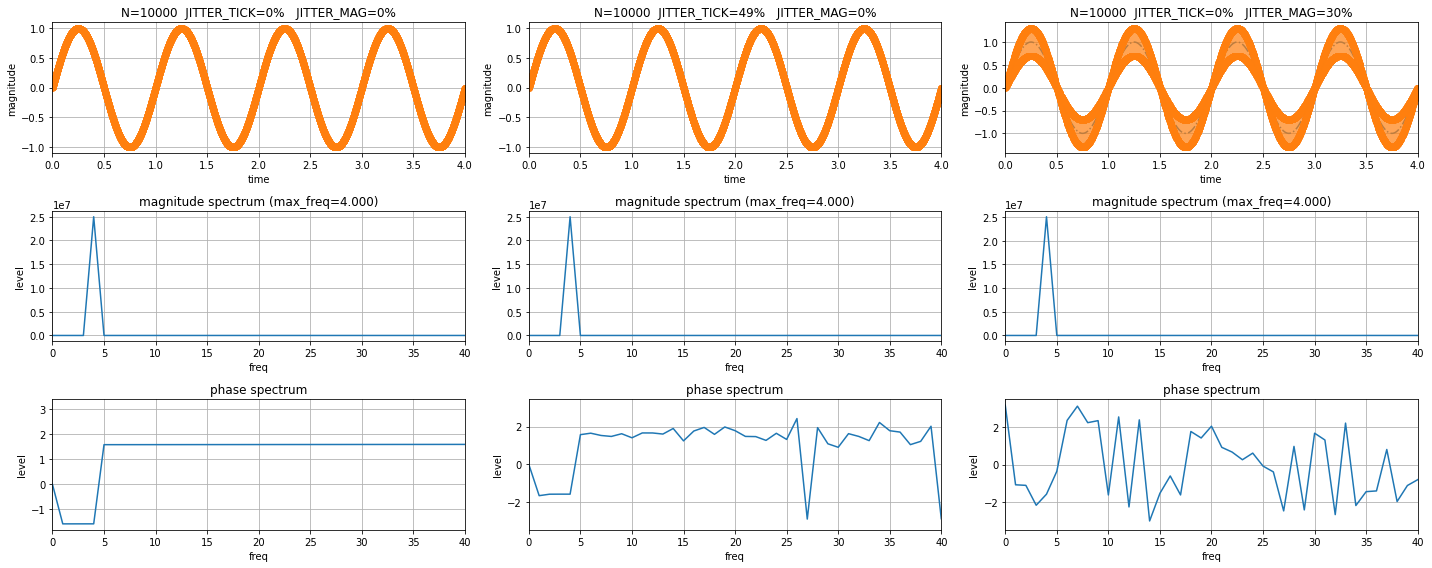

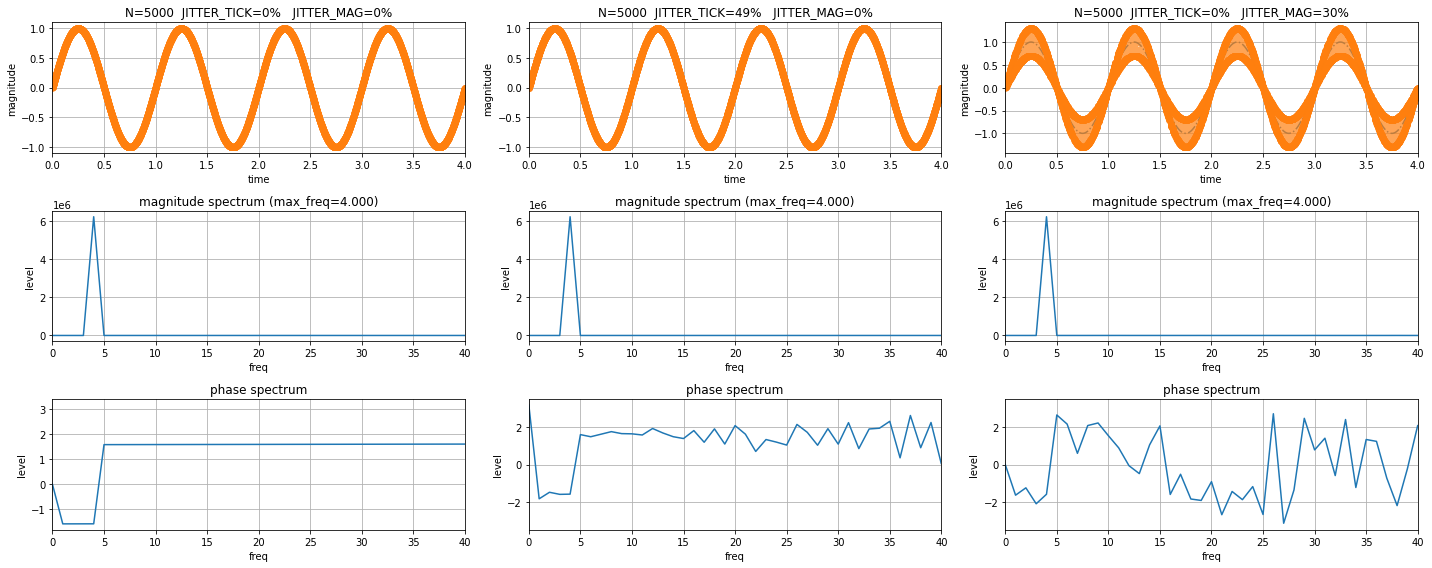

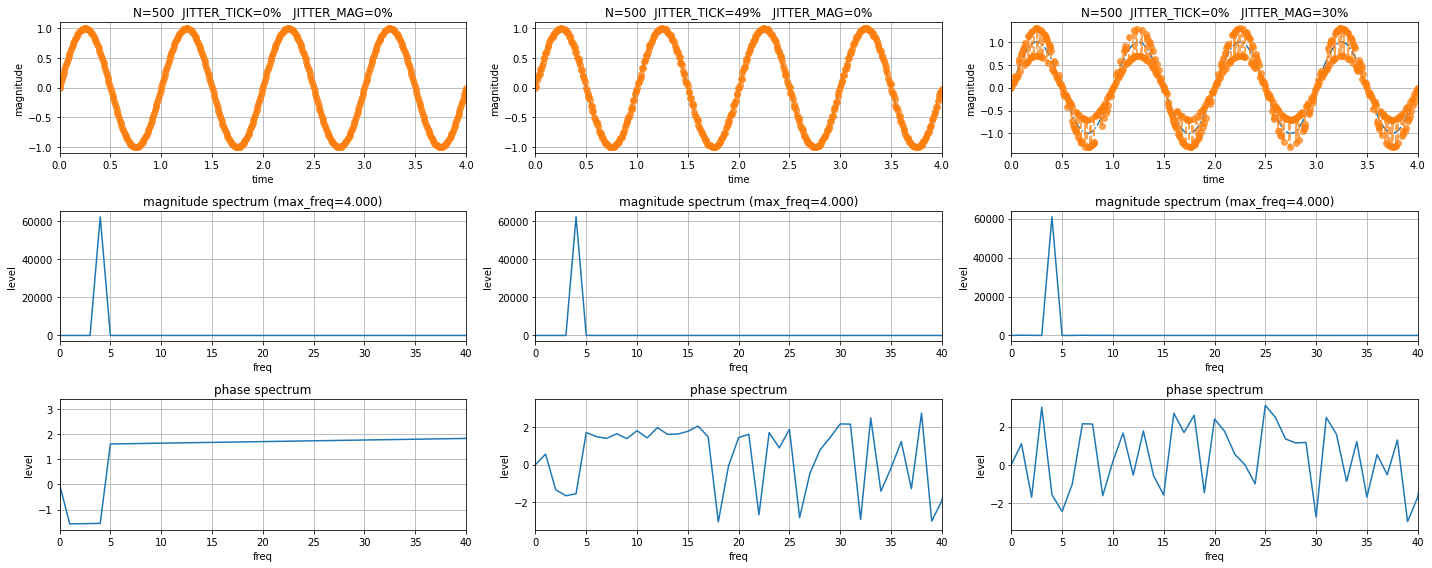

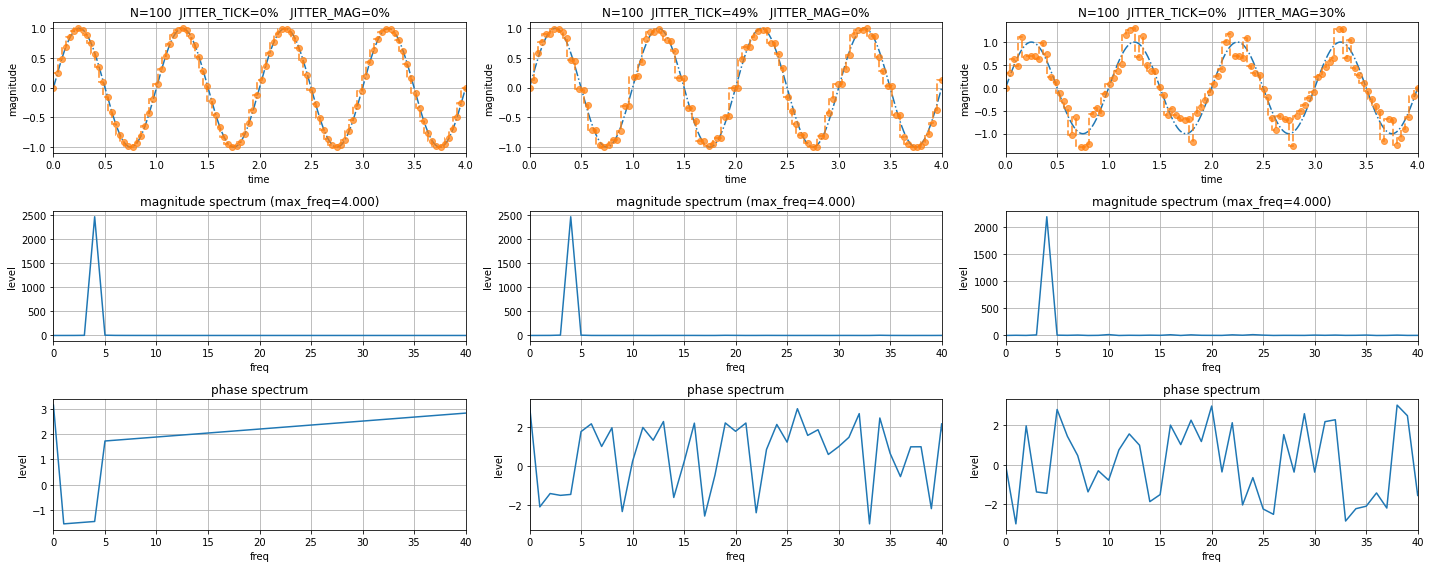

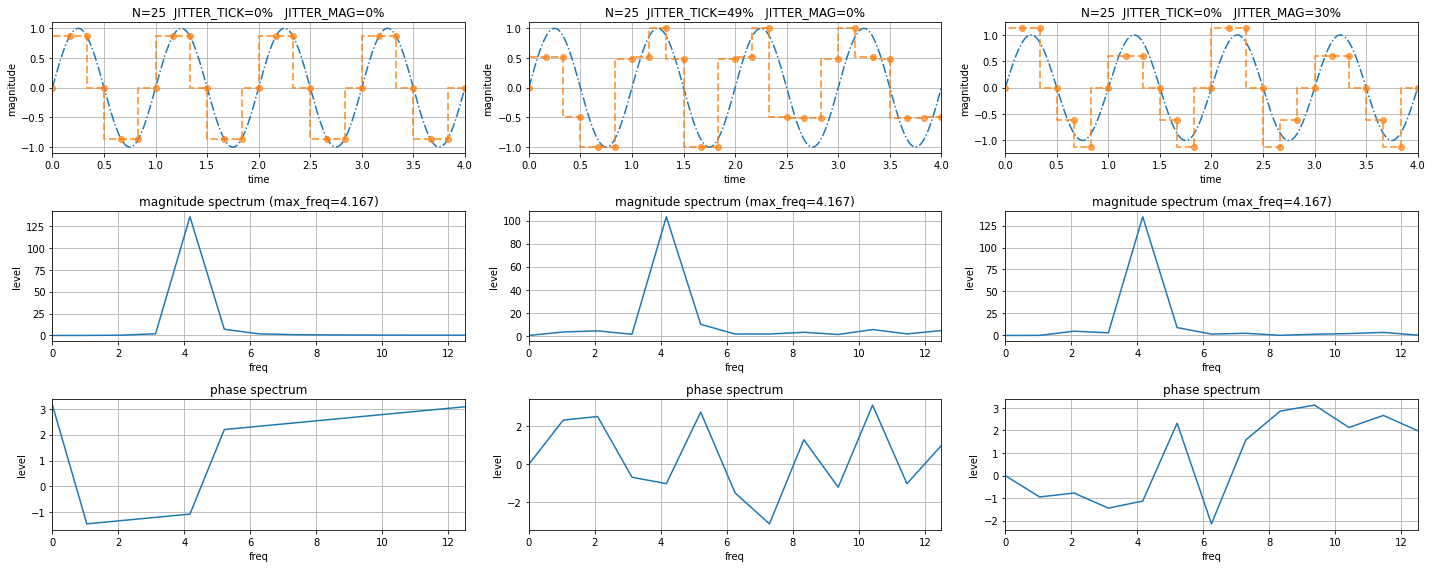

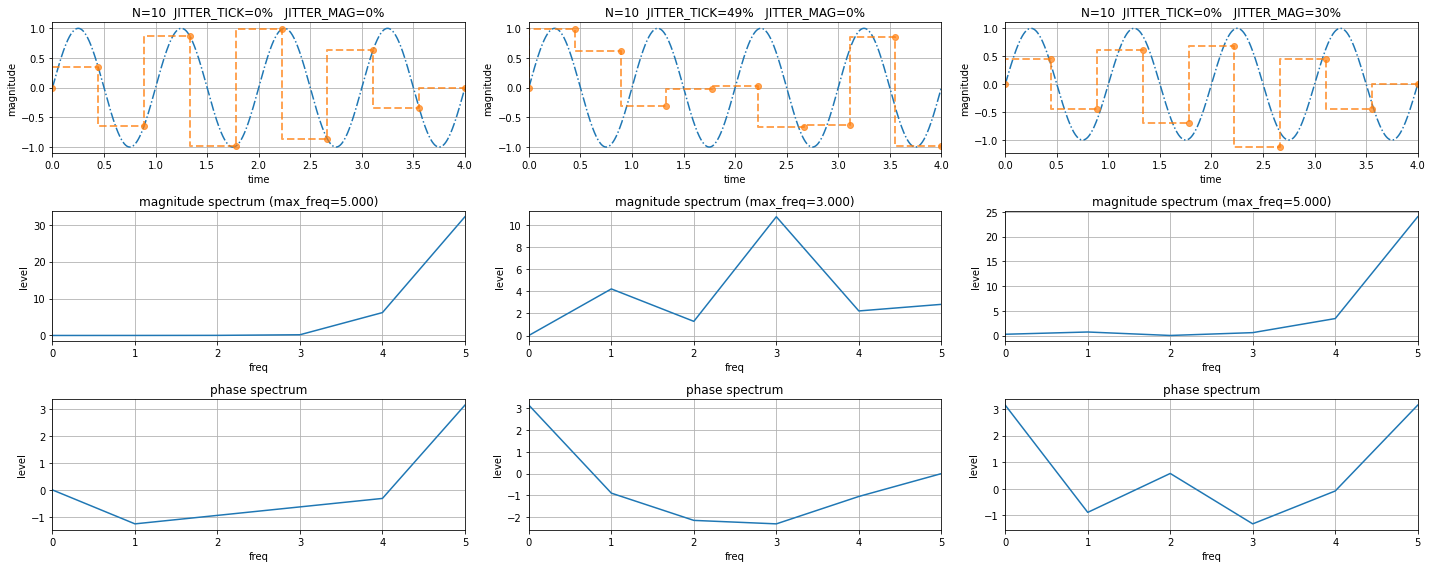

In [4]:
SIN_FREQ = 4

ideal_x, ideal_y = sin_tick(10000, SIN_FREQ)

N_FFT = 2048

for i, (sampling_rate, jit_tick, jit_amp) in enumerate((
    (10000, 49, 30),
    (5000, 49, 30),
    (500, 49, 30),
    (100, 49, 30),
    (25, 49, 30),
    (10, 49, 30),
)):
    fig = plt.figure(figsize=(20, 8))
    variants = (
        (0, 0),
        (jit_tick, 0),
        (0, jit_amp),
#         (jit_tick, jit_amp),
    )
    for i, (jit_tick, jit_amp) in enumerate(variants):
        plt.subplot(3, len(variants), i + 1)
        plt.plot(ideal_x, ideal_y, '-.')
        plt.xlim((ideal_x[0], ideal_x[-1]))
        plt.grid()
        plt.title(f'N={sampling_rate}  JITTER_TICK={jit_tick}%   JITTER_MAG={jit_amp}%')

        x, y = sin_tick_rand_jitter(sampling_rate, SIN_FREQ, jit_tick, jit_amp)
        plt.step(x, y, '--o', linewidth=2.0, alpha=0.7)
        plt.xlabel("time")
        plt.ylabel("magnitude")

        y_fft = np.fft.rfft(y, len(y))
        magnitude_spectrum = np.square(np.abs(y_fft))
        # The power spectrum is calculated as the square of
        # the absolute value of the discrete Fourier transform
        # https://www.kite.com/python/answers/how-to-plot-a-power-spectrum-in-python

        freq = np.linspace(0, sampling_rate/2, len(magnitude_spectrum))

        df = pd.DataFrame({"magnitude_level": magnitude_spectrum, "freq": freq})

        max_freq = df.iloc[df['magnitude_level'].idxmax()]['freq']

        # spectrum
        plt.subplot(3, len(variants), i + 1 + len(variants))
        plt.grid()
        plt.title(f'magnitude spectrum (max_freq={max_freq:0.3f})')
        plt.xlabel("freq")
        plt.ylabel("level")
        plt.xlim([freq[0], min(max_freq * 10, freq[-1])])
        plt.plot(freq, magnitude_spectrum)

        # phase
        phase_spectrum = np.angle(y_fft)
        plt.subplot(3, len(variants), i + 1 + 2 * len(variants))
        plt.grid()
        plt.title('phase spectrum')
        plt.xlabel("freq")
        plt.ylabel("level")
        plt.xlim([freq[0], min(max_freq * 10, freq[-1])])
        plt.plot(freq, phase_spectrum)

    plt.tight_layout()
    plt.show()


# Convolution

In [6]:
T = TypeVar('T')

def convolution(s1: List[T], s2: List[T]) -> List[T]:
    s1, s2 = (s1, s2) if len(s1) > len(s2) else (s2, s1)
    z = [0] * (len(s2) - 1)
    ps = z + list(s1) + z
    s2_i = list(range(len(s2)))
    return [sum(ps[i+j] * s2[-j-1] for j in s2_i) for i in range(len(s1) + len(z))]

In [14]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18, 20]

[]

In [12]:
%%timeit
c = convolution(a, b)

57.9 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
np.array(convolution(a, b))

array([  1,   4,  10,  20,  35,  56,  84, 120, 165, 220, 275, 330, 385,
       440, 495, 550, 605, 660, 714, 768, 801, 812, 800, 764, 703, 616,
       502, 360, 200])

# AM 

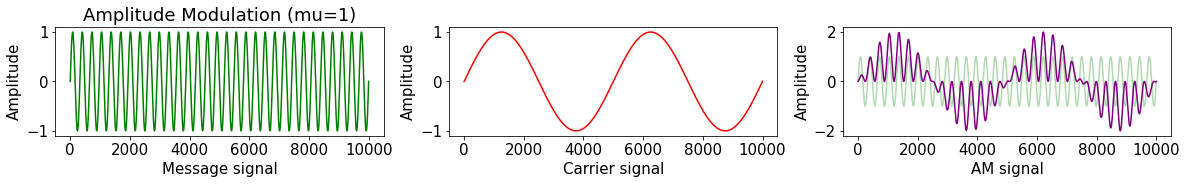

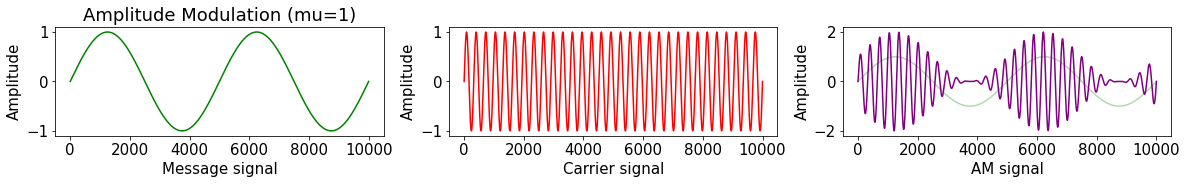

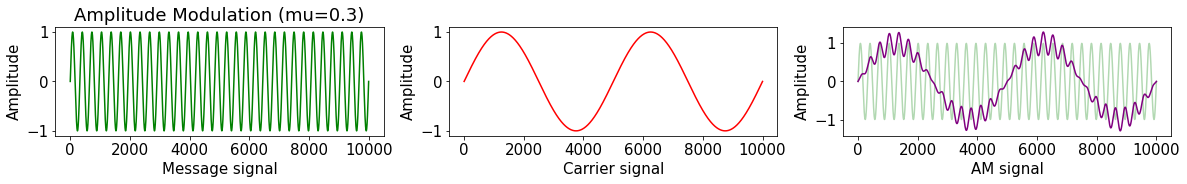

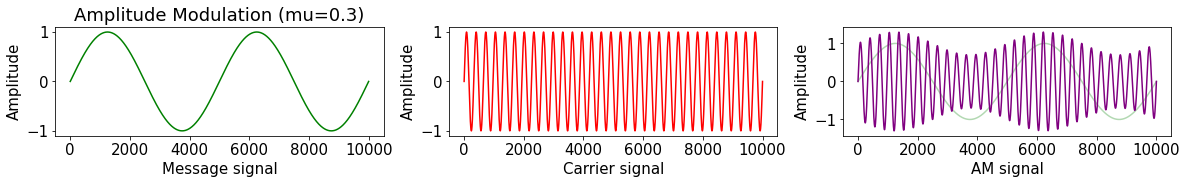

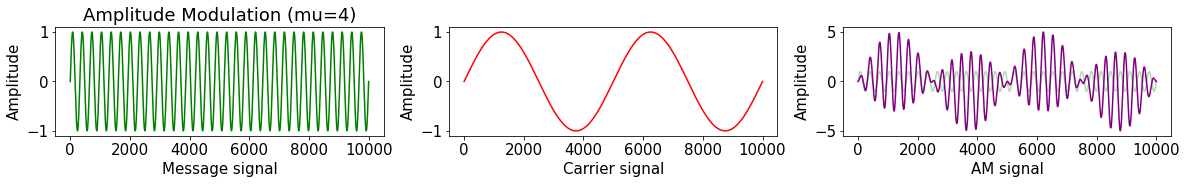

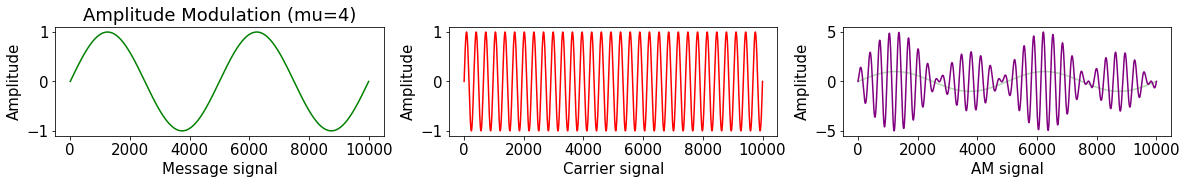

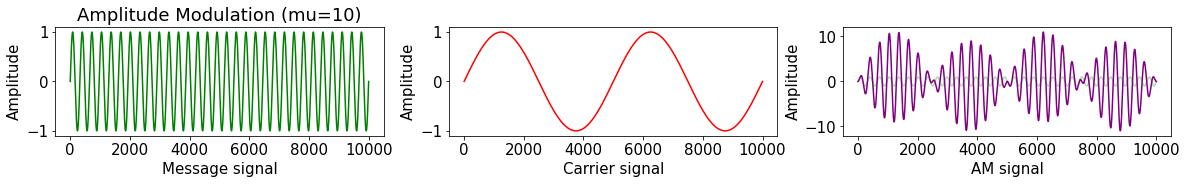

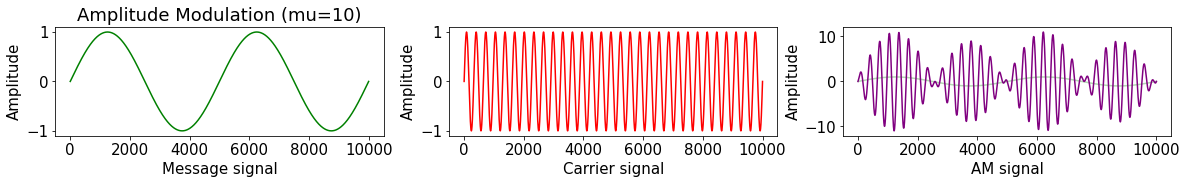

In [38]:
t = np.linspace(0, 1, 10000)
for f_c, f_m, mu in (
    (2, 31, 1),
    (31, 2, 1),
    (2, 31, 0.3),
    (31, 2, 0.3),
    (2, 31, 4),
    (31, 2, 4),
    (2, 31, 10),
    (31, 2, 10),
):
    fig = plt.figure(figsize=(20, 2))

    carrier = np.sin(2*np.pi*f_c*t)
    modulator = np.sin(2*np.pi*f_m*t)
    product = (1+mu*modulator)*carrier

    plt.subplot(1,3,1)
    plt.title(f'Amplitude Modulation (mu={mu})')
    plt.plot(modulator,'g')
    plt.ylabel('Amplitude')
    plt.xlabel('Message signal')

    plt.subplot(1,3,2)
    plt.plot(carrier, 'r')
    plt.ylabel('Amplitude')
    plt.xlabel('Carrier signal')

    plt.subplot(1,3,3)
    plt.plot(modulator,'g', alpha=0.3)
    plt.plot(product, color="purple")
    plt.ylabel('Amplitude')
    plt.xlabel('AM signal')

    plt.subplots_adjust(hspace=1)
    plt.rc('font', size=15)
    fig = plt.gcf()
